In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgbm
import time
import gc
%matplotlib inline

# TalkingData AdTracking Fraud Detection Challenge

Summary

- Classification problem
- Target variable = is_attributed
- Leaderboard performance measure = AUC

Input features:

- ip: ip address of click - **categorical**
- app: app id for marketing - **categorical**
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.) - **categorical**
- os: os version id of user mobile phone - **categorical**
- channel: channel id of mobile ad publisher - **categorical**
- click_time: timestamp of click (UTC) - **ordinal**
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download - **ordinal**
- is_attributed: the target that is to be predicted, indicating the app was downloaded - **binary**

Note that ip, app, device, os, and channel are encoded.

### Load and preview input data

In [17]:
df = pd.read_csv('../input/train_sample.csv')
print(df.shape)
df.head()

(100000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


Mostly categorical features - record them as such and look at their cardinality:

In [18]:
categorical_features = ['ip', 'app', 'device', 'os', 'channel']
for feat in categorical_features:
    print('Feature {} has {} unique values.'.format(feat, len(df[feat].unique())))

Feature ip has 34857 unique values.
Feature app has 161 unique values.
Feature device has 100 unique values.
Feature os has 130 unique values.
Feature channel has 161 unique values.


It will be interesting to see how we use the IP feature as one-hotting it may be a challenge!

What does the label distribution look like?

In [19]:
df['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

Wow... heavily imbalanced dataset.

Process the click_time and attributed_time features into more useful formats

In [20]:
df['click_time'] = pd.to_datetime(df['click_time'], infer_datetime_format=True)
df['attributed_time'] = pd.to_datetime(df['attributed_time'], infer_datetime_format=True)

In [21]:
df['numeric_clicktime'] = pd.to_numeric(df['click_time'])
df['numeric_att_time'] = pd.to_numeric(df['attributed_time'])
df['click_weekday'] = df['click_time'].dt.weekday
df['click_hour'] = df['click_time'].dt.hour

In [22]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,numeric_clicktime,numeric_att_time,click_weekday,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,1510047038000000000,-9223372036854775808,1,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,1510062027000000000,-9223372036854775808,1,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,1510077924000000000,-9223372036854775808,1,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,1510030688000000000,-9223372036854775808,1,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,1510218009000000000,-9223372036854775808,3,9


In [23]:
sum(df['attributed_time'].isnull())

99773

## Modelling section

Borrowing from here...

https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code

In [24]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, 
                      categorical_features=None):
    
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

In [25]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train_df = pd.read_csv('../input/train_sample.csv', 
#                        skiprows=range(1,144903891), 
#                        nrows=40000000, 
                       dtype=dtypes, 
                       usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
#  Note usecols here is not loading attributed_time

# print('loading test data...')
# test_df = pd.read_csv(path + "test.csv", 
#                       dtype=dtypes, 
#                       usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

len_train = len(train_df)
print('Train set rows: {}'.format(len_train))
# train_df = train_df.append(test_df)

# del test_df
gc.collect()

Train set rows: 100000


61

## Feature extraction

In [26]:
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

Group by a number of combinations to add features

In [27]:
print('grouping by ip-day-hour combination...')
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})
train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
del gp
gc.collect()

print('grouping by ip-app combination...')
gp = train_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()


print('grouping by ip-app-os combination...')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()


# Adding features with var and mean hour (inspired from nuhsikander's script)
print('grouping by : ip_day_chl_var_hour')
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_tchan_count'})
train_df = train_df.merge(gp, on=['ip','day','channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_os_var_hour')
gp = train_df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_channel_var_day')
gp = train_df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_chl_mean_hour')
gp = train_df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
print("merging...")
train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

grouping by ip-day-hour combination...
grouping by ip-app combination...
grouping by ip-app-os combination...
grouping by : ip_day_chl_var_hour
grouping by : ip_app_os_var_hour
grouping by : ip_app_channel_var_day
grouping by : ip_app_chl_mean_hour
merging...


118

In [28]:
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
ip                          100000 non-null uint32
app                         100000 non-null uint16
device                      100000 non-null uint16
os                          100000 non-null uint16
channel                     100000 non-null uint16
click_time                  100000 non-null object
is_attributed               100000 non-null uint8
hour                        100000 non-null uint8
day                         100000 non-null uint8
ip_tcount                   100000 non-null int64
ip_app_count                100000 non-null int64
ip_app_os_count             100000 non-null int64
ip_tchan_count              10877 non-null float64
ip_app_os_var               10285 non-null float64
ip_app_channel_var_day      15166 non-null float64
ip_app_channel_mean_hour    100000 non-null float64
dtypes: float64(4), int64(3), object(1), uint16(4), uint32(1), uint8(3)
memory 

In [29]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,0,9,7,1,3,2,NaN,24.5,NaN,9.0
1,105560,25,1,17,259,2017-11-07 13:40:27,0,13,7,4,4,1,19.0,NaN,0.25,11.5
2,101424,12,1,19,212,2017-11-07 18:05:24,0,18,7,1,1,1,NaN,NaN,NaN,18.0
3,94584,13,1,13,477,2017-11-07 04:58:08,0,4,7,1,1,1,NaN,NaN,NaN,4.0
4,68413,12,1,1,178,2017-11-09 09:00:09,0,9,9,1,2,1,NaN,NaN,NaN,9.0


In [30]:
# test_df = train_df[len_train:]
val_df = train_df[(len_train-20000):len_train]
train_df = train_df[:(len_train-20000)]

target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour', 'day', 
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour']
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']

# sub = pd.DataFrame({'click_id': test_df['click_id'].astype('int')})

gc.collect()

print("Training...")
start_time = time.time()


params = {
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 99 # because training data is extremely unbalanced 
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

Training...
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.987254	valid's auc: 0.992132
[20]	train's auc: 0.992944	valid's auc: 0.993442


C:\Users\James\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	train's auc: 0.99536	valid's auc: 0.991527
[40]	train's auc: 0.996024	valid's auc: 0.992435
[50]	train's auc: 0.996653	valid's auc: 0.990277
Early stopping, best iteration is:
[23]	train's auc: 0.994336	valid's auc: 0.993867

Model Report
n_estimators :  23
auc: 0.9938672952293568


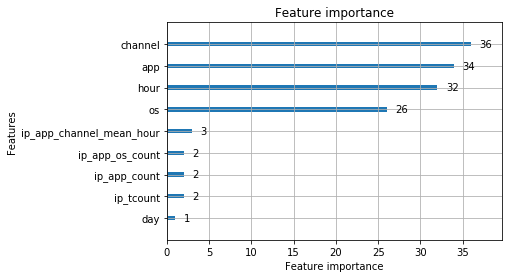

In [33]:
lgbm.plot_importance(booster=bst)
plt.show()